In [1]:
# 导入常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体支持（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

## 0.读取数据

In [2]:
# 读取训练数据
df = pd.read_csv('train.csv') 

# 查看前几行数据
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.缺失值的检测与缺失值处理

In [3]:
# 统计缺失值
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("缺失值统计（从高到低）：")
print(missing_data)

缺失值统计（从高到低）：
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


将数据分为“分类列”和“数值列”，“分类列”的缺失值统一用“None”填充，“数值列”的缺失值使用KNN方法来进行填充。同时，注意到有些数值类的数据其实表达的是“分类”的涵义，应把这些数据列单独加入“分类列”。

In [4]:
# 获取所有分类列
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# 获取数值列
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 移除 SalePrice（不要对目标变量插补）
if 'SalePrice' in num_cols:
    num_cols.remove('SalePrice')

# 手动修正：把一些应该是分类的数字也加入分类列
special_categorical = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YrSold']
for col in special_categorical:
    if col in num_cols:
        num_cols.remove(col)
        cat_cols.append(col)

# 对每个分类列填充 'None'
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna('None')

# 对每个数值型使用 KNN 填补缺失值
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [5]:
print("处理后缺失值总数：", df.isnull().sum().sum())  # 应为 0

处理后缺失值总数： 0


## 2.异常值检测
选取关键特征，通过**可视化（箱线图 + 散点图**）和 **量化分析（IQR**）来检测出异常值。同时，不仅关注单变量异常值，也关注“**双变量异常值**”（比如价格+面积，有些面积很大的却价格很低，可能存在异常）。

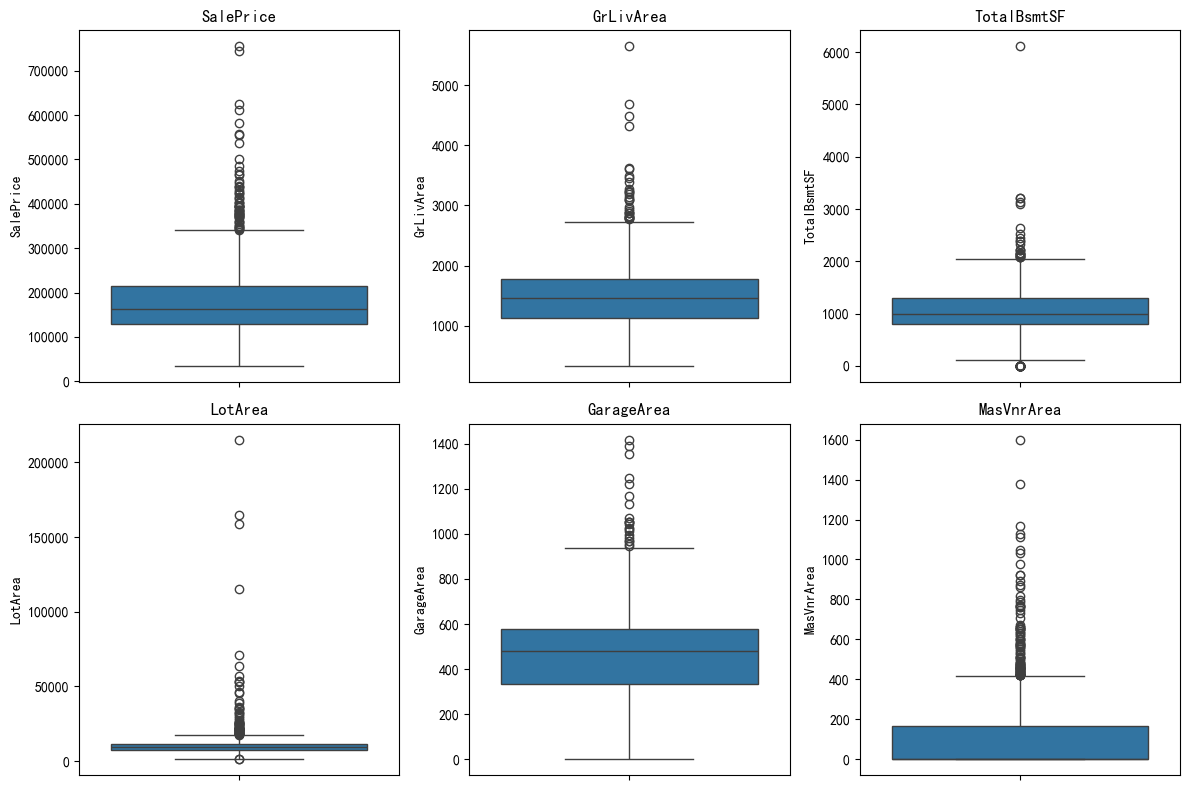

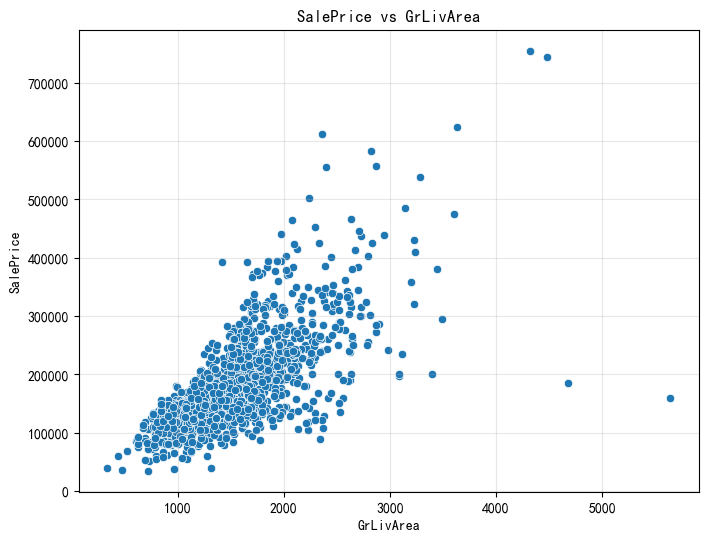

在任一关键特征上检测到的异常值总数: 241
房价的异常值有61个
地上生活面积的异常值有31个
地下室面积的异常值有61个
车库面积的异常值有21个
地块面积的异常值有69个
砖石面积的异常值有97个


In [6]:
# 选择关键数值特征
features = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'LotArea', 'GarageArea','MasVnrArea']

# 绘制箱线图
plt.figure(figsize=(12, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 散点图：价格 vs 面积（检测联合异常）
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
plt.title('SalePrice vs GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.grid(True, alpha=0.3)
plt.show()

# IQR 法量化异常值
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)].index

# 统计有多少样本在任一关键特征上为异常
all_outliers = set()
for col in features:
    all_outliers.update(detect_outliers(df[col]))

print(f"在任一关键特征上检测到的异常值总数: {len(all_outliers)}")
print(f'房价的异常值有{len(detect_outliers(df["SalePrice"]))}个')
print(f'地上生活面积的异常值有{len(detect_outliers(df["GrLivArea"]))}个')
print(f'地下室面积的异常值有{len(detect_outliers(df["TotalBsmtSF"]))}个')
print(f'车库面积的异常值有{len(detect_outliers(df["GarageArea"]))}个')
print(f'地块面积的异常值有{len(detect_outliers(df["LotArea"]))}个')
print(f'砖石面积的异常值有{len(detect_outliers(df["MasVnrArea"]))}个')

## 3.特征相关分析

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156     0.008619 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.379764 -0.139781     0.032628   
LotFrontage    0.008619   -0.379764     1.000000  0.423628     0.211875   
LotArea       -0.033226   -0.139781     0.423628  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.211875  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.032563 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.091515  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.054591  0.013788     0.550684   
MasVnrArea    -0.049337    0.022269     0.175572  0.103732     0.413004   
BsmtFinSF1    -0.005024   -0.069836     0.235538  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.071386  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.105681 -0.002618     0.308159   
TotalBsmtSF   -0.015415  

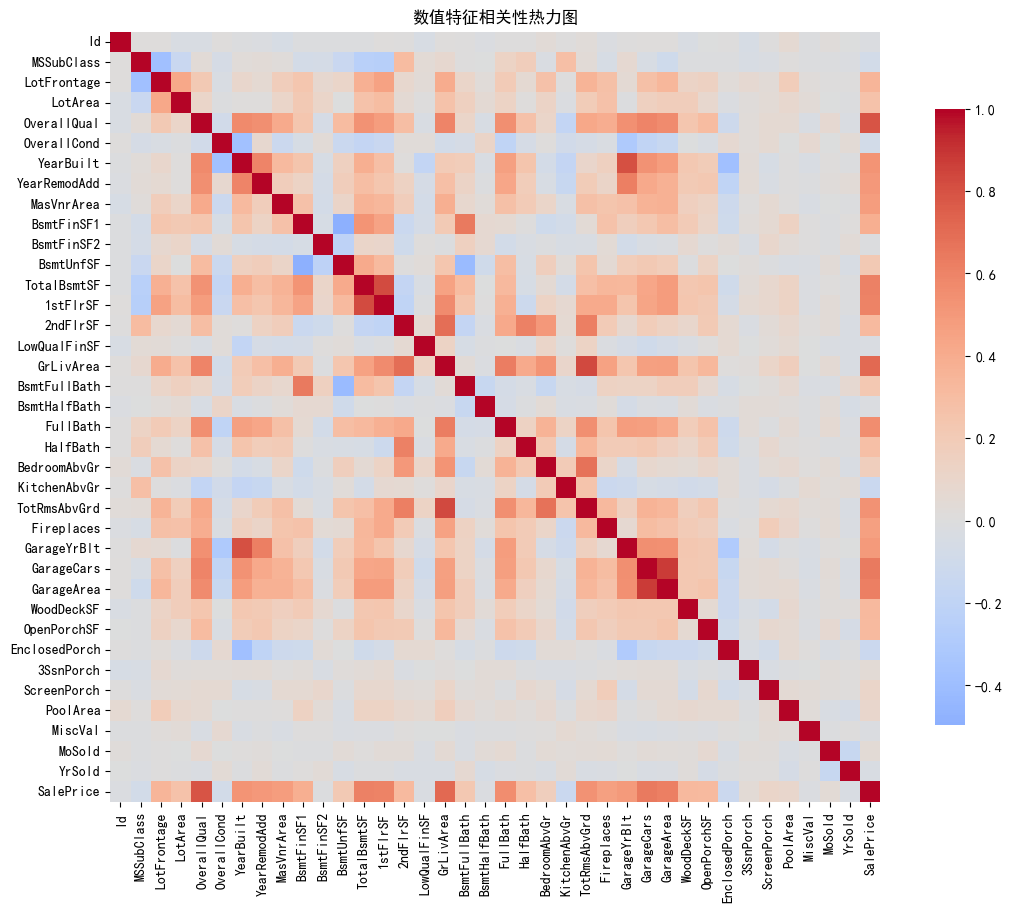

In [7]:
# 只保留数值型变量
numeric_df = df.select_dtypes(include=[np.number])

# 计算相关性矩阵
corr_matrix = numeric_df.corr()

print(corr_matrix)

# 绘制热力图
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, 
            cbar_kws={"shrink": .8})
plt.title('数值特征相关性热力图')
plt.show()


## 4.对price属性进行标准化

In [8]:
# 初始化标准化器
scaler = StandardScaler()

# 对 SalePrice 进行标准化
df['SalePrice_scaled'] = scaler.fit_transform(df[['SalePrice']])

# 查看结果
print("标准化后 price 的均值和标准差：")
print(df['SalePrice_scaled'].describe()[['mean', 'std']])

标准化后 price 的均值和标准差：
mean    1.362685e-16
std     1.000343e+00
Name: SalePrice_scaled, dtype: float64


## 5.根据price属性进行离散化
使用 KBinsDiscretizer 将连续房价划分为 5 个等级。

In [9]:
# 初始化离散化器（5 个区间，等宽）
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
df['SalePrice_bin'] = discretizer.fit_transform(df[['SalePrice']])

# 转换为类别标签以便理解
labels = ['Low', 'Lower-Mid', 'Medium', 'Upper-Mid', 'High']
df['SalePrice_category'] = pd.cut(df['SalePrice'], bins=5, labels=labels)

# 显示离散化后结果
df[['SalePrice', 'SalePrice_bin', 'SalePrice_category']]


,SalePrice,SalePrice_bin,SalePrice_category
0,208500,1.0,Lower-Mid
1,181500,1.0,Lower-Mid
2,223500,1.0,Lower-Mid
3,140000,0.0,Low
4,250000,1.0,Lower-Mid
...,...,...,...
1455,175000,0.0,Low
1456,210000,1.0,Lower-Mid
1457,266500,1.0,Lower-Mid
1458,142125,0.0,Low


## 6.找出与price相关性最高的三个特征

In [10]:
# 获取与 SalePrice 的相关性排序
corr_with_price = corr_matrix['SalePrice'].sort_values(ascending=False)

# 排除自身，取前3
top3_features = corr_with_price[1:4]  # 第一个是 SalePrice 自身
print("与房价相关性最高的三个特征：")
print(top3_features)

与房价相关性最高的三个特征：
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
Name: SalePrice, dtype: float64


对三个相关性最高的特征的合理解释：
1. **OverallQual（整体质量）**:  
   房屋的建材、工艺和装修水平直接决定其市场价值。高质量房屋更受欢迎，价格更高。

2. **GrLivArea（地上生活面积）**:  
   居住空间是购房者最关注的因素之一。面积越大，使用功能越强，价格自然越高。

3. **GarageCars（车库容量）**:  
   车位数量反映房屋配套完整性。大车库通常出现在高档社区，也意味着更大的土地和更高的建造成本。